# The Encoder-Decoder Transformer
We have seen Encoder only and Decoder only Transformers in the last weeks and today we take a look at the orginal proposed architecture that involves both elements. It is perfect for Sequence to Sequence models like Translation tasks.

After taking a look at the Data-Flow and how Encoder and Decoder interact, we train a summarization model that can summerize Reddit posts into shorter "too long didn't read" versions.

## The Encoder Decoder Data-Flow

This time we show you a few time steps of a translation. We translate "I love you!" to the German equivalent "Ich liebe dich!". We just drop the last step in which we predict a "!".

### Step 1

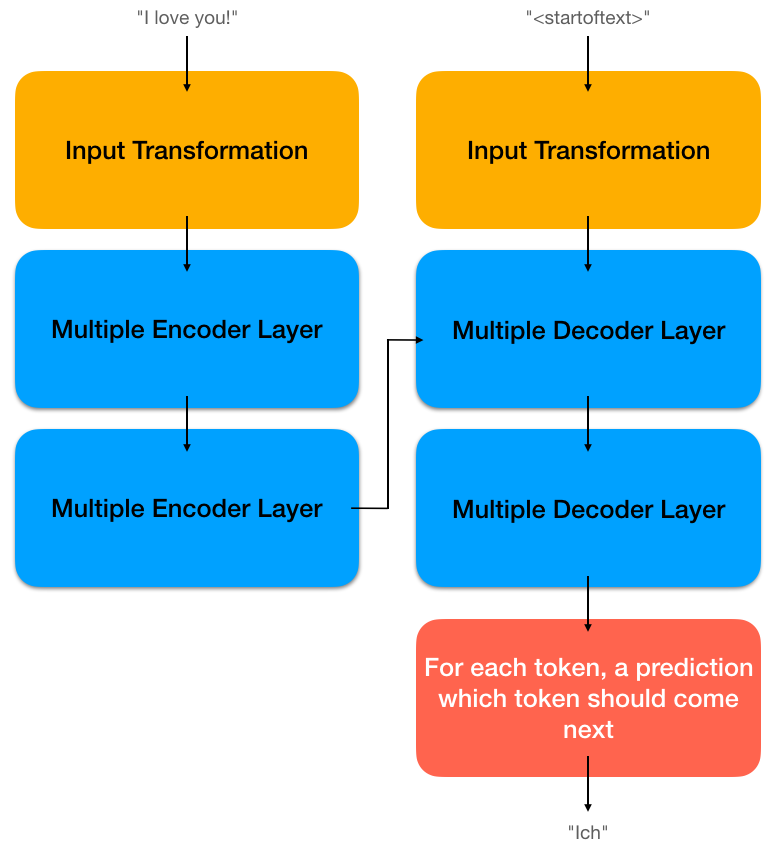

### Step 2

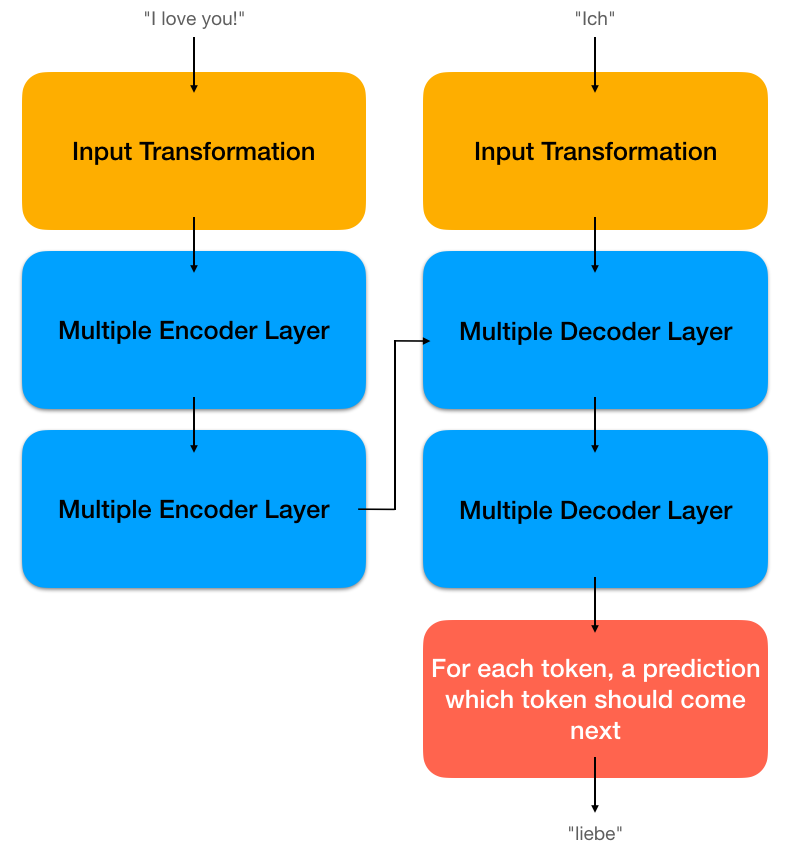

### Step 3

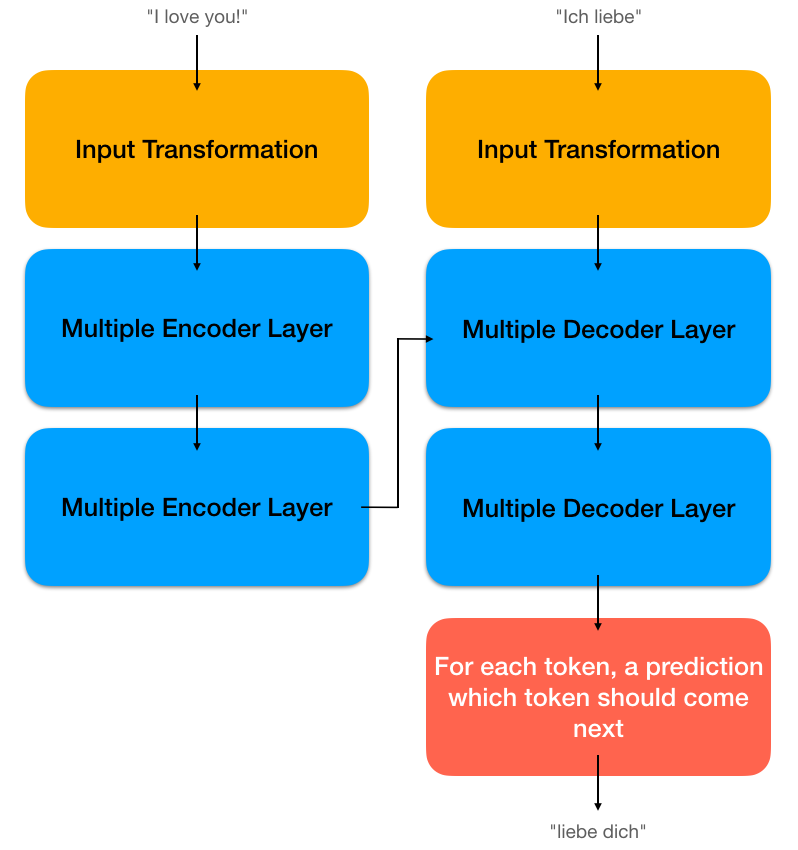

## How Encoder and Decoder Layer(s) interact

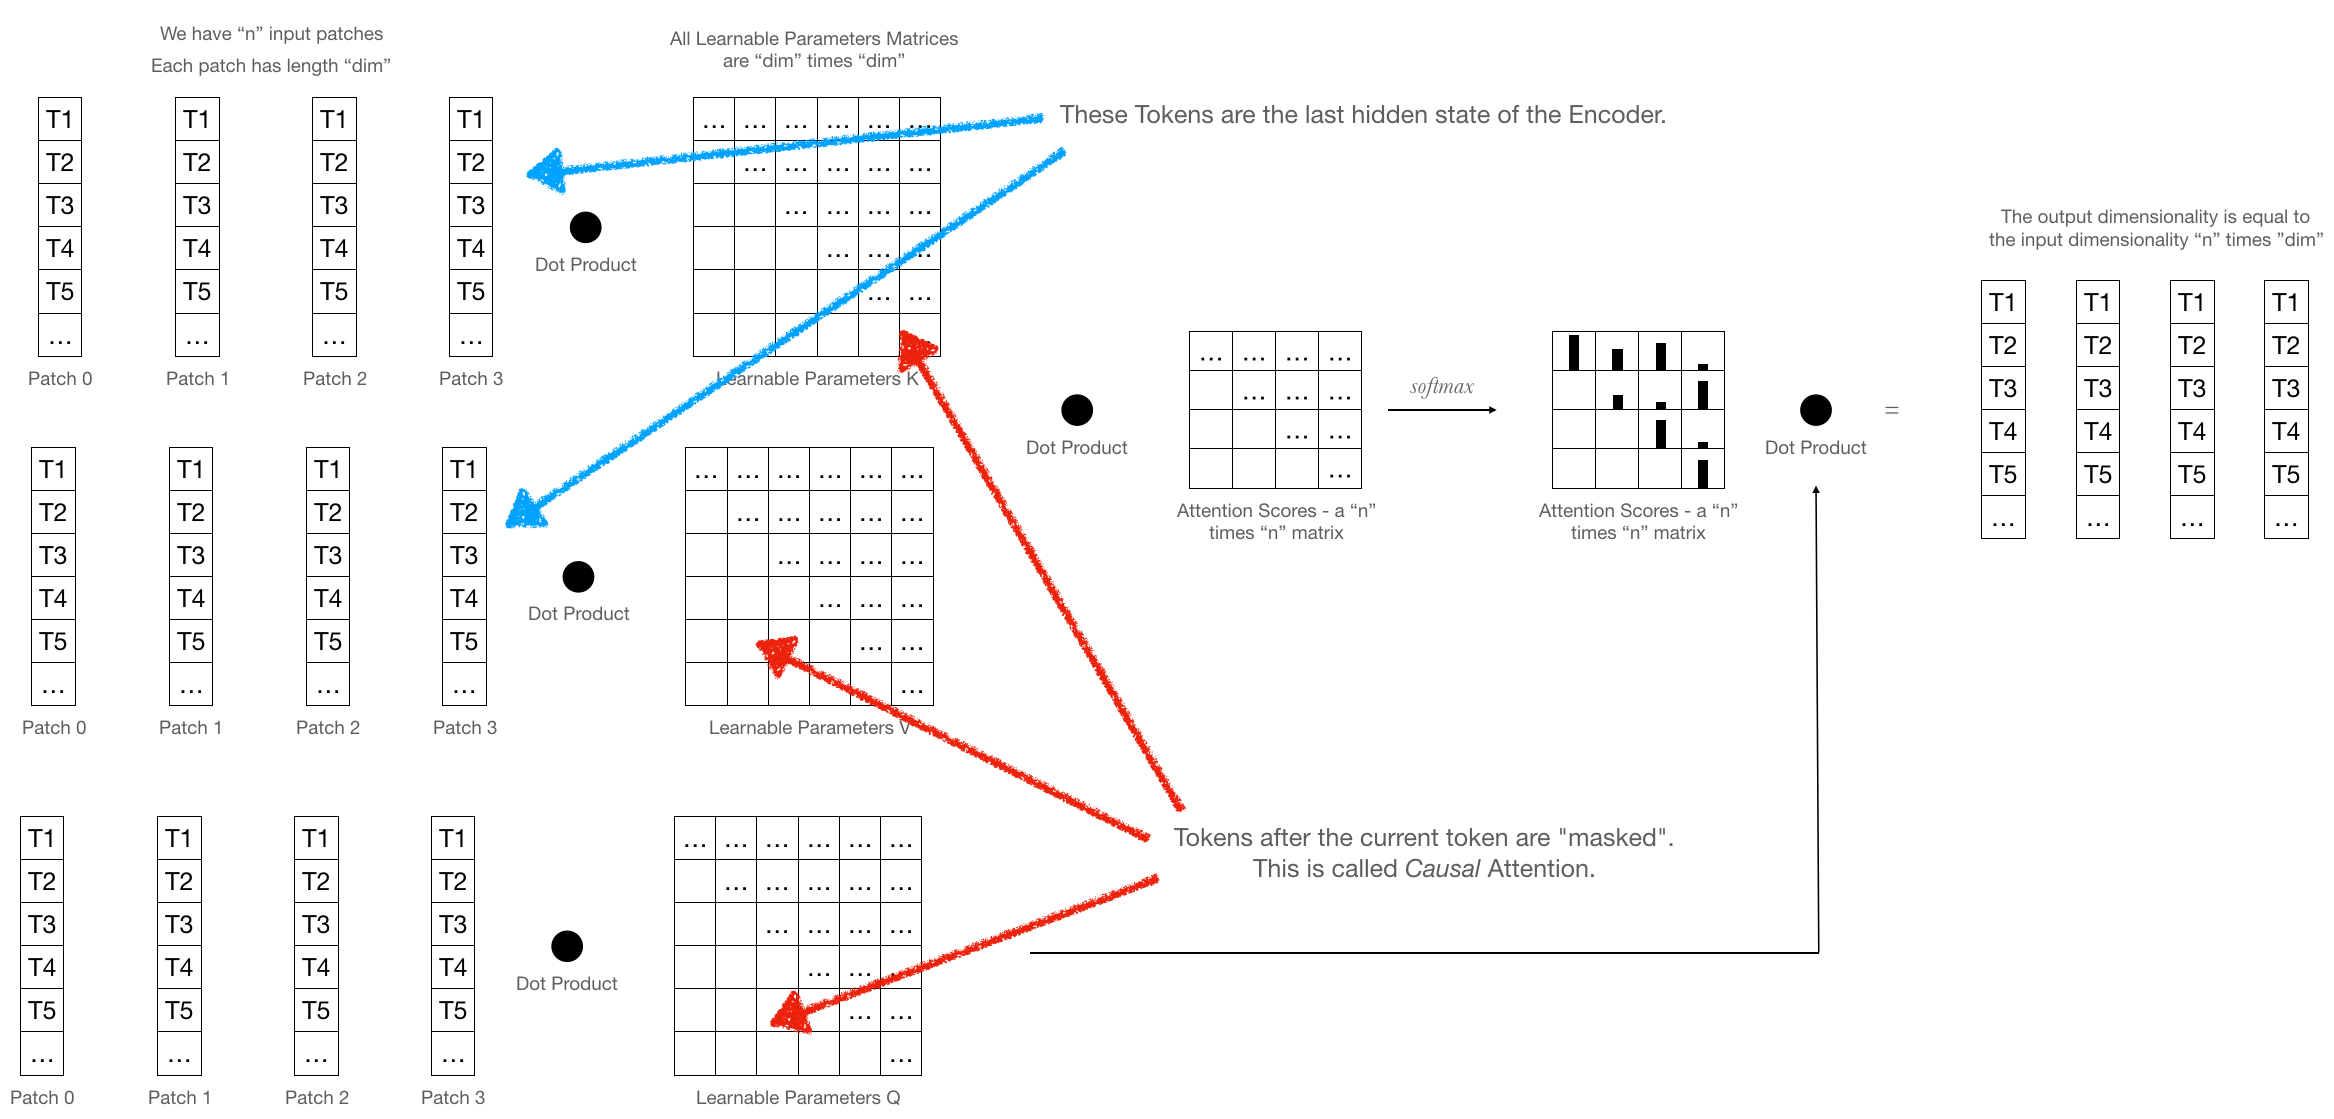

# Setup

In [ ]:
# Setup
# This cell installs all the dependencies used in this week - imports happen as we go
%%capture
!pip install transformers==4.24.0 datasets evaluate rouge_score nltk optimum[onnxruntime]

import nltk
nltk.download('punkt')

# From Idea To Production - A Capstone Project 

## Create Your own Reddit Summarization Service

It's time to wrap it all up - train an Endcoder-Decoder Transformer (a BART model from Meta) and optimize it for production. After that we will apply all the knowledge we have about embeddings to identify out-of-distribution behaviour e.g. when our model recieves input or generates texts we do not want it to process and or produce.

You might already be familiar with loading datasets fom Huggingface. This is a dataset of Reddit posts where authors decided to leave a "TL;DR" (too long didn't read) summary for impatient readers. Since the main post and the summary have a different writing style this is a Sequence to Sequence task - perfect for the Encoder-Decoder Transformer. Using the "most complex" version of the standard Transformer architecture also comes with the benefit of more effective context length since the input text does not share space with the output text.

⚠️ Reddit is an online community that had and has some unristricted content 

In [ ]:
# You know the drill, streaming=True and sample!
from datasets import load_dataset


reddit = load_dataset("reddit", split="train", streaming=True)
shuffled_reddit = reddit.shuffle(seed=42, buffer_size=2000)

In [ ]:
# Again, we can fetch a few samples through itertools
import itertools

N = 200
reddit_sample = list(itertools.islice(iter(shuffled_reddit), N))

In [ ]:
# Data is more easy to explore in Pandas
import pandas as pd

df = pd.DataFrame(reddit_sample)

In [ ]:
# We are most interested in the content and summary columns
df

As introduced in last session we can let Huggingface do the train-test split and create a DatasetDict.

In [ ]:
from datasets import Dataset, DatasetDict

ds = Dataset.from_pandas(df).train_test_split(test_size=0.15)

We initialise the BART model in the usual way. This time we explicitly load a configuration prepared by the people who pretrained the model.

In [ ]:
from transformers import AutoConfig, AutoTokenizer, AutoModelForSeq2SeqLM


tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")
config = AutoConfig.from_pretrained("facebook/bart-base")

# Bart uses a byte-level Byte-Pair-Encoding - it can treat spaces as part of words
# The default for this behaviour is: turned off
model = AutoModelForSeq2SeqLM.from_pretrained(
    "facebook/bart-base",
    config=config
)

Again, we define a preprocessing function. This time it has to process inputs of the Encoder and Decoder and the desired Decoder output we calculate our loss on is called "labels". To incentive the pretrained model to generate a summarization we us the "summarize" prompt.

In [ ]:
text_column = "content"
summary_column = "summary"
prefix = "summarize: "

padding = "max_length"
max_source_length = 1024 # as mentioned above we have this space for input and output each
max_target_length = 128  # ... but we force the summaries to be "short"
ignore_pad_token_for_loss=True


def preprocess_function(examples):
    inputs, targets = [], []

    # Unpack the examples
    for i in range(len(examples[text_column])):
        if examples[text_column][i] and examples[summary_column][i]:
            inputs.append(examples[text_column][i])     # This goes into the Encoder
            targets.append(examples[summary_column][i]) # This goes into the Decoder

    # Tokenize Encoder Inputs
    inputs = [prefix + inp for inp in inputs]
    model_inputs = tokenizer(inputs, max_length=max_source_length, padding=padding, truncation=True)

    # Tokenize Decoder Inputs
    labels = tokenizer(text_target=targets, max_length=max_target_length, padding=padding, truncation=True)

    # Optionally, apply padding
    if padding == "max_length" and ignore_pad_token_for_loss:
        labels["input_ids"] = [
            [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
        ]

    # The tokenizer results are dicts, we can easily add the labels as a new property
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
# Before Preprocessing
ds

If we do not remove all columns not needed for the model, the Data Collator will blindly tokenize everything and the model might crash where dicts are unpacked as kwargs via **dict because of unexpected kwargs. Amazing!

In [ ]:
tokenized_ds = ds.map(preprocess_function, batched=True, remove_columns=ds["train"].column_names)

In [ ]:
# After Preprocessing
tokenized_ds

Of course, there is a specialised Data Collator for jsut this task.

In [ ]:
from transformers import DataCollatorForSeq2Seq


data_collator = DataCollatorForSeq2Seq(
        tokenizer,
        model=model,
        label_pad_token_id=tokenizer.pad_token_id
    )


### Huggingface Metrics

Huggingface hosts scripts to calculate the metrics used in publiscations to train models like BERT, Bart and so on.

**ROUGE** (Recall-Oriented Understudy for Gisting Evaluation) is family of metrics published by Google in 2004 to measure translation tasks. In 2017 they added a summary oriented metric: *rougeLSum*

In [ ]:
# The evaluate package has been installed in the setup cell at the top of this notebook
import evaluate


metric = evaluate.load("rouge")

For this task we need a postprocessing function that alters the output to fit the parameters of the *rougeLSum* metric.

In [ ]:
# Did you expect us impoting NLTK ever again! Surprise!
import nltk


def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects a newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels

The Huggingface Trainer can work with any metric passed as the "compute_metrics" parameter. You will often see that people call the function to be called jsut as the parameter.

In [ ]:
import numpy as np


def compute_metrics(eval_preds):

    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    if True:
        # Replace -100 in the labels as we can't decode them.
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    result = {k: round(v * 100, 4) for k, v in result.items()}
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    return result


### Training a Sequence-to-Sequence model

Hopefully, this shows the power of the Huggingface Trainer. There is so much to keep an eye on during this training, losses, metrics, different spaces... As last week, we do not have enough time to let you train a full model during this session.

In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
import torch

torch.cuda.empty_cache()

# Initialize our Trainer
args = Seq2SeqTrainingArguments(
    output_dir="bart-reddit",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    evaluation_strategy="steps",
    eval_steps=6,
    logging_steps=6,
    gradient_accumulation_steps=8,
    num_train_epochs=2,
    weight_decay=0.1,
    warmup_steps=1_000,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    save_steps=6,
    load_best_model_at_end=True,
    save_total_limit=4,
    generation_max_length=max_target_length,
    predict_with_generate=True
    #fp16=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [ ]:
# Let's go!
trainer.train()

In [ ]:
# Let's try the results of this mini trainig
# First, we tokenize a post
example = next(iter(shuffled_reddit))

tokenized_content = tokenizer(example["content"], return_tensors="pt")


# Then, we let the model run multiple times though the generate method until 
# it encoutners a <|endoftext|> or reaches a deined max_length
generated = model.generate(input_ids=tokenized_content["input_ids"].cuda(), 
                            attention_mask=tokenized_content["attention_mask"].cuda(),
                            temperature=0.9,
                            early_stopping=True,
                            do_sample=True,
                            max_new_tokens=max_target_length)

In [ ]:
# Now we just have to decode the tokens to characters
tokenizer.batch_decode(generated, skip_special_tokens=True)

In [ ]:
# And this is the "truth"
example["summary"]

# Fast in Production - Quantization

You probably want to run these large models as fast as possible in production, but they come with high resource needs. First, let's compare using GPU or CPU for inference and than move on to optimization for CPU via Quantization.

In [ ]:
# We need a single test observation and a batch test - the tokenizer is super fast and not part of this comparision

single = tokenized_content

batch = {
    "input_ids": tokenized_content["input_ids"].repeat(5, 1),
    "attention_mask": tokenized_content["attention_mask"].repeat(5, 1)
}

### GPU - Single

In [ ]:
%%timeit -n 1 -r 5
model.generate(input_ids=single["input_ids"].cuda(), 
                            attention_mask=single["attention_mask"].cuda(),
                            temperature=0.9,
                            early_stopping=True,
                            do_sample=True,
                            max_new_tokens=max_target_length)

### GPU - Batch

In [ ]:
%%timeit -n 1 -r 5
model.generate(input_ids=batch["input_ids"].cuda(), 
                            attention_mask=batch["attention_mask"].cuda(),
                            temperature=0.9,
                            early_stopping=True,
                            do_sample=True,
                            max_new_tokens=max_target_length)

As long as there is enough RAM a GPU parallelizes perfectly.

To test the CPU performance, we haev to move our model to CPU.

In [ ]:
model = model.to('cpu')

### CPU - Single

In [ ]:
%%timeit -n 1 -r 5
model.generate(input_ids=single["input_ids"], 
                            attention_mask=single["attention_mask"],
                            temperature=0.9,
                            early_stopping=True,
                            do_sample=True,
                            max_new_tokens=max_target_length)

### CPU - Batch

In [ ]:
%%timeit -n 1 -r 5
model.generate(input_ids=batch["input_ids"], 
                            attention_mask=batch["attention_mask"],
                            temperature=0.9,
                            early_stopping=True,
                            do_sample=True,
                            max_new_tokens=max_target_length)

So far so good, CPU is way slower and in batch mode it does not parallelize well. But GPUs are expensive and you might not have them where the models need to run.

### Apply Quantization via Optimum

To use Huggingface's implementation adapter of the Microsoft ONNX Runtime we have to save our model to disk. It's a good practice to add the matching Tokenizer to the same directory.

In [ ]:
model.save_pretrained("amazing_summarization_model")
tokenizer.save_pretrained("amazing_summarization_model")

In [ ]:
%%capture
!pip install -U tensorflow==2.10 

In [ ]:
from optimum.onnxruntime import ORTModelForSeq2SeqLM
from optimum.onnxruntime.configuration import AutoQuantizationConfig

quantization_model = ORTModelForSeq2SeqLM.from_pretrained("./amazing_summarization_model", from_transformers=True)

### Optimized - Single

In [ ]:
%%timeit -n 1 -r 5
quantization_model.generate(input_ids=single["input_ids"], 
                            attention_mask=single["attention_mask"],
                            temperature=0.9,
                            early_stopping=True,
                            do_sample=True,
                            max_new_tokens=max_target_length)

### Optimized - Batch

In [ ]:
%%timeit -n 1 -r 5
quantization_model.generate(input_ids=batch["input_ids"], 
                            attention_mask=batch["attention_mask"],
                            temperature=0.9,
                            early_stopping=True,
                            do_sample=True,
                            max_new_tokens=max_target_length)

As we can see, Quantization reduced the compute time for single predictions, but hardly helped with Batches. As a rule of thumb: Do not use CPUs for batch predictions.

In [ ]:
# Clean up out limited memory
del quantization_model
del ds
del tokenized_ds

# Detecting Out of distribution Inputs and Putputs
In this final section of the course we want to identify potential abuse of our models by identifing inputs we should not predict on - the same techinque can be used on outputs as well. This area of deep learning research is still in its infancy and there are no "one-size-fits-all-solutions" yet. Huggingface currently does not include any tooling to do so.

In week 3 we built a search engine that allowed search through similarity in the latent space. Well, we can use distance in latent space to define "too different from what we noramlly do", too. There are many ways to do so - one could use attention similarity, CLS token similarity, mean embedding similarity and so on...

For this example we will make use of the fact that Reddit consists of different communities called Subreddits that discuss "different" topics. We can setup an OOD example by pretending that some subreddits contain "unwelcome" content.

For the sake of time we do not use the entire dataset here, again.

In [ ]:
# The full reddit are 2000 posts - take it or leave it :P
reddit_full = list(itertools.islice(iter(shuffled_reddit), 2000))

In [ ]:
df_full = pd.DataFrame(reddit_full)
df_full

Let's remember that all these models are doing is basically finding space transformations - and for checking undesired inputs we would choose the last hidden state of the encoder.

In [ ]:
def batch_embed_in_latent_space(text, model=model, tokenizer=tokenizer):
    tokenized_text = tokenizer(text, return_tensors="pt", max_length=1024, padding=True, truncation=True)

    # We set output_hidden_states to True to return encoder and decoder hidden states
    outputs = model(input_ids=tokenized_text["input_ids"].cuda(), attention_mask=tokenized_text["attention_mask"].cuda(), output_hidden_states=True)

    # But eventually we are only interested in the encoder_last_hidden_state
    return outputs.encoder_last_hidden_state.detach().cpu().numpy()[:,0]  #.mean(axis=1)

This looks similar to building an Annoy index and indeed it is very similar - we embed all the examples and calculate a mean per subreddit. This is a very simplistic method, but quite effective.

In [ ]:
import random
from tqdm import tqdm
from collections import defaultdict
import torch

batch_size = 8
n_batches = N // batch_size
f = 768  # Length of item vector that will be indexed
unique_id = 0

subreddit_spaces = defaultdict(list)

# Move model back to GPU
model.cuda()

for i in tqdm(range(n_batches)):
    batch = [post for post in df_full.to_dict('records')[i * batch_size : (1 + i) * batch_size]]
    with torch.no_grad():
        batched_output = batch_embed_in_latent_space([post["content"] for post in batch], model=model, tokenizer=tokenizer)

    for vector, post in zip(batched_output, batch):
        subreddit_spaces[post["subreddit"]].append(vector)

In [ ]:
# Here we calculate the mean 768 embedding dimensions per subreddit
mean_subreddit_spaces = {}

for subreddit, vectors in subreddit_spaces.items():
    mean_subreddit_spaces[subreddit] = np.mean(vectors, axis=0)

Now, having a mean representation of each subreddit we can calculate their pairwise similarity to define which subreddits are "hostile". For an in production "filter" we could instead create a Gaussian Mixture Model.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

n = len(mean_subreddit_spaces.values())
a = np.zeros((n, n))

values = list(mean_subreddit_spaces.values())

for y in range(n):
    for x in range(n):
        a[y][x] = cosine_similarity(values[y].reshape(1, -1), values[x].reshape(1, -1))

In [ ]:
# Visual inspection shows that therer are very similar and less similar subreddits - good!
import seaborn as sns

sns.heatmap(a)

Let's create a histogram of similarieties - you could have one for incoming requests in production.

In [ ]:
similarities = []

for y in range(n):
    for x in range(n - y, n):
        similarities.append(a[y][x])

In [ ]:
pd.Series(similarities).plot.hist()

Let's find the most unsimilar Subreddits

In [ ]:
y_i, x_i = np.unravel_index(a.argmin(), a.shape)

In [ ]:
list(mean_subreddit_spaces.keys())[y_i], list(mean_subreddit_spaces.keys())[x_i], a[y_i][x_i]

And the most similar subreddits

In [ ]:
sorted_index_pairs = np.unravel_index(np.argsort(a, axis=None), a.shape)

In [ ]:
y_i, x_i = sorted_index_pairs[0][-n -1], sorted_index_pairs[1][-n -1]

In [ ]:
list(mean_subreddit_spaces.keys())[y_i], list(mean_subreddit_spaces.keys())[x_i], a[y_i][x_i]

From here, we could define a threshold of similarity for inputs and inputs falling below it would not be processed. Similarly, we could check the emebddings of our outputs and cancel "risky" outputs before they are sent as a response.